#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [ ]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



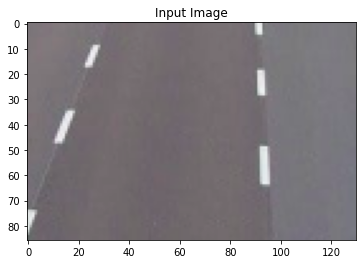


Detected line is: x1= 0  y1= 83  ,x2= 25 ,y2= 9

Detected line is: x1= 92  y1= 0  ,x2= 95 ,y2= 64

Detected line is: x1= 1  y1= 81  ,x2= 27 ,y2= 9

Detected line is: x1= 90  y1= 0  ,x2= 92 ,y2= 63


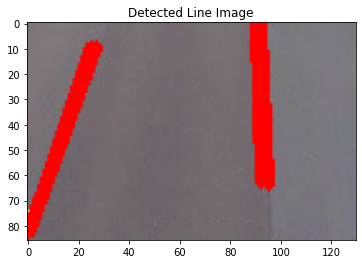

In [ ]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####
minlinelen = 60
maxgap = 250
thres = 15
angle = np.pi/180


lines = cv2.HoughLinesP(edges,rho = 1,theta = angle,threshold = thres,minLineLength = minlinelen,maxLineGap = maxgap)
for line in lines:
    x1, y1, x2, y2 = line[0]
    print("\nDetected line is: x1=",x1," y1=",y1," ,x2=",x2,",y2=",y2)
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)


#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [ ]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(90/100 * num_points)
        inliers = int(10/100 * num_points)
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = np.dot(A, points_s[:, :inliers]) + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ###
        points_num = points_s.shape[1]
        M = np.zeros((2 * points_num, 6))

        for i in range(points_num):
            temp = [[points_s[0, i], points_s[1, i], 0, 0, 1, 0],
                    [0, 0, points_s[0, i], points_s[1, i],0, 1]]
            M[2 * i: 2 * i + 2, :] = np.array(temp)

        b = points_t.T.reshape((2 * points_num, 1))
        theta = np.linalg.lstsq(M, b)[0]
        A = theta[:4].reshape((2, 2))
        t = theta[4:]

        return A, t

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE
        if not(A is None) and not(t is None):
            points_e = np.dot(A, points_s) + t
            diff_square = np.power(points_e - points_t, 2)
            residual = np.sqrt(np.sum(diff_square, axis=0))

        return residual


        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        inliers_num = 0
        A = None
        t = None
        inliers = np.array([], dtype=int)

        for i in range(ITER_NUM):
            idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
            A_temp, t_temp = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
            residual = self.calculate_distance(A_temp, t_temp, points_s, points_t)
            if not(residual is None):
                inliers_tmp = np.where(residual < self.thr)
                inliers_num_tmp = len(inliers_tmp[0])
                if inliers_num_tmp > self.L and inliers_num_tmp > inliers_num:
                    inliers_num = inliers_num_tmp
                    inliers = inliers_tmp
                    A = A_temp
                    t = t_temp

        return A, t, inliers
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(101,)


## Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



Number of pixels counted at corners: 222


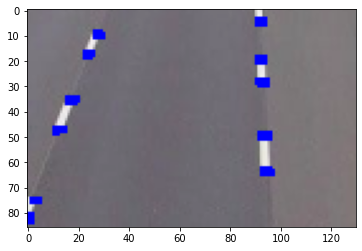

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
## STEP 2: Detect corners 
dest = cv2.cornerHarris(gray, 2, 3, 0.04)
## STEP 3: Dilate corner image to enhance corner points
dest = cv2.dilate(dest,None)
## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
thres = 0.1 * dest.max()
## STEP 5: Count numer of detected corner points and draw them on the image
image_copy[dest > thres] = [0, 0, 255]

plt.imshow(image_copy,cmap='gray')
thresh = 200
corner_count = 0

for j in range(dest.shape[0]):
  for i in range(dest.shape[1]): 
    if dest[j,i] > thres:
      corner_count +=1 
    
  
print("Number of pixels counted at corners:", corner_count)
### YOUR CODE ENDS HERE

We get 11 corners as visible in the image shown above

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [ ]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a transforms for preparing the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307, ), (0.3081,))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [ ]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1,16,3,1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16,32,3,1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32,64,3,1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)    
        x = torch.flatten(x,1)    
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [ ]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 9.953s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [ ]:
tr_loss =[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        tr_loss.append(loss.item())

In [ ]:
accuracy = []
te_loss = []

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    te_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [ ]:
model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)



start = timeit.default_timer()
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
stop = timeit.default_timer()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304365
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.006578
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.856460
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.361304
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.259815
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.581979
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.404547
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.410964
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.299378
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.116280
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.534302
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.074008
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.181166
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.149232
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.117556
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.511161
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.466299
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.478477
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.369955
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.141655
Train Epoch: 0 [12800/60000 (

In [ ]:
print("Total time: ", int(stop - start), "seconds")

Total time:  469 seconds


Text(0.5, 1.0, 'train loss')

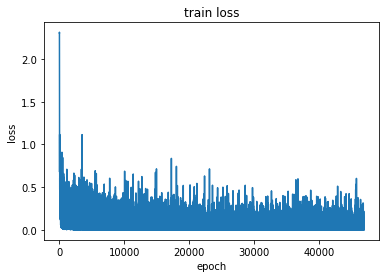

In [ ]:
plt.plot(tr_loss, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')

Text(0.5, 1.0, 'test loss')

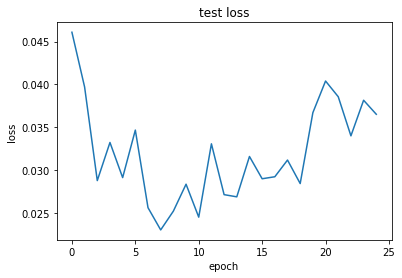

In [ ]:
plt.plot(te_loss, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('test loss')

Text(0.5, 1.0, 'test accuracy')

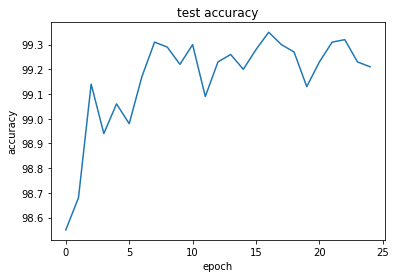

In [ ]:
plt.plot(accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('test accuracy')

In [ ]:
print("Last accuracy with ReLU: ", accuracy[-1])

Last accuracy with ReLU:  99.21


### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1,16,3,1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16,32,3,1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32,64,3,1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        x = self.maxpool(x)
        x = self.drop1(x)    
        x = torch.flatten(x,1)    
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.drop2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output


tr_loss =[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        tr_loss.append(loss.item())

accuracy = []
te_loss = []

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    te_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))

model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

start = timeit.default_timer()
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
stop = timeit.default_timer()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.387636
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.284081
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.407278
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.333844
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.451838
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.416822
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.464483
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.175609
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.323140
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.367652
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.345302
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.419882
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.370634
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.319402
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.325701
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.323325
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.441993
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.299871
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.366493
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.337328
Train Epoch: 0 [12800/60000 (

In [ ]:
print("Last accuracy with Sigmoid: ", accuracy[-1])

Last accuracy with Sigmoid:  99.2


We see that the last accuracy of model using ReLU activation was 99.21, and with Sigmoid activation is 99.20
The accuracy drops in Signmoid as Sigmoid has lower convergence performance than ReLU. We can say the with Sigmoid is getting lower accuracy as it cannot converge to an optimal solution in 25 iterations. It may get better results if we let the model run longer.
This may also be possible due to experimental error and may be considered same accuracy. 

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [ ]:
optimizers_list = ['Adadelta','Adagrad','ASGD','SGD']
lastaccuracy = []
lasttestloss =[]
lasttrainloss =[]

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1,16,3,1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16,32,3,1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32,64,3,1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####
 
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)    
        x = torch.flatten(x,1)    
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output
 
tr_loss =[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        tr_loss.append(loss.item())
 
accuracy = []
te_loss = []
 
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
 
    test_loss /= len(test_loader.dataset)
 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    te_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))
 
model = Net().to(device)
 
 
optimizer = torch.optim.Adadelta(model.parameters(),lr=0.001)
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
lastaccuracy.append(accuracy[-1])
lasttestloss.append(te_loss[-1])
lasttrainloss.append(tr_loss[-1])
 
 
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.001)
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
lastaccuracy.append(accuracy[-1])
lasttestloss.append(te_loss[-1])
lasttrainloss.append(tr_loss[-1])
 
optimizer = torch.optim.ASGD(model.parameters(),lr=0.001)
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
lastaccuracy.append(accuracy[-1])
lasttestloss.append(te_loss[-1])
lasttrainloss.append(tr_loss[-1])
 
 
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
lastaccuracy.append(accuracy[-1])
lasttestloss.append(te_loss[-1])
lasttrainloss.append(tr_loss[-1])

Streaming output truncated to the last 5000 lines.
Train Epoch: 23 [28160/60000 (47%)]	Loss: 0.067880
Train Epoch: 23 [28800/60000 (48%)]	Loss: 0.023134
Train Epoch: 23 [29440/60000 (49%)]	Loss: 0.187666
Train Epoch: 23 [30080/60000 (50%)]	Loss: 0.005092
Train Epoch: 23 [30720/60000 (51%)]	Loss: 0.028055
Train Epoch: 23 [31360/60000 (52%)]	Loss: 0.011915
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.070203
Train Epoch: 23 [32640/60000 (54%)]	Loss: 0.066711
Train Epoch: 23 [33280/60000 (55%)]	Loss: 0.057287
Train Epoch: 23 [33920/60000 (57%)]	Loss: 0.034899
Train Epoch: 23 [34560/60000 (58%)]	Loss: 0.004167
Train Epoch: 23 [35200/60000 (59%)]	Loss: 0.044932
Train Epoch: 23 [35840/60000 (60%)]	Loss: 0.013341
Train Epoch: 23 [36480/60000 (61%)]	Loss: 0.100945
Train Epoch: 23 [37120/60000 (62%)]	Loss: 0.127450
Train Epoch: 23 [37760/60000 (63%)]	Loss: 0.053204
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.028643
Train Epoch: 23 [39040/60000 (65%)]	Loss: 0.023468
Train Epoch: 23 [39680/60000 (6

In [ ]:
for idx, opt in enumerate(optimizers_list):
  print("Optimizer: ", opt, "Last Accuracy: ", lastaccuracy[idx])

Optimizer:  Adadelta Last Accuracy:  95.21
Optimizer:  Adagrad Last Accuracy:  98.85
Optimizer:  ASGD Last Accuracy:  98.96
Optimizer:  SGD Last Accuracy:  99.08


We tested with other optimizers namely, Adadelta, Adagrad, ASGD and SGD. The accuracy achived by each optimizer is given above. 
Where Adam optmizer got an accuracy of 99.21, the others have a lower accuracy on the same model.

In comparison to SGD, Adam converges faster hence gets better results than SGD.

AdaDelta uses exponentially decaying average of 2nd moment of gradient. 

Adagrad scales alpha for each parameter according to the history of gradients (previous steps) for that parameter which is basically done by dividing current gradient in update rule by the sum of previous gradients. As a result, what happens is that when the gradient is very large, alpha is reduced and vice-versa.

Adam uses both first order moment and 2nd order moment but they are both decayed over time. Step size decreases, as it approaches minimum. So it includes the best of momentum and RMSProp to get the best result of all other optimizers.

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1,16,3,1)
        self.conv1.weight.data.fill_(1)
        self.conv1.bias.data.fill_(1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16,32,3,1)
        self.conv2.weight.data.fill_(1)
        self.conv2.bias.data.fill_(1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32,64,3,1)
        self.conv3.weight.data.fill_(1)
        self.conv3.bias.data.fill_(1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)    
        x = torch.flatten(x,1)    
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

tr_loss =[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        tr_loss.append(loss.item())

accuracy = []
te_loss = []

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    te_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))

model = Net().to(device)


optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

start = timeit.default_timer()
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
stop = timeit.default_timer()

Train Epoch: 0 [0/60000 (0%)]	Loss: 184145.843750
Train Epoch: 0 [640/60000 (1%)]	Loss: 1029.468994
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.300556
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.306710
Train Epoch: 0 [2560/60000 (4%)]	Loss: 1180.313110
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.313436
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.312535
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.308143
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.295845
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.287771
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.307798
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.291209
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.306936
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.297694
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.311820
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.291881
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.303794
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.298874
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.298782
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.306972
Train Epoch: 0 [12

In [ ]:
print("Accuracy with weights and bias set to 1: ", accuracy[-1])

Accuracy with weights and bias set to 1:  11.35


When training with weights and and bias set to 1, we see that the accuracy achived is 11.35 which is equal to random guessing accuracy. This happens because with all weghts set to 1, the network suffers from weight space symmerty. Due to this the weights at all layers are updated the same way and by same amount. Similiarly, the bias is also set same for all the neurons in a layer and also between multiple layers.

When this happens, the network cannot learn anything new from the dataset provided and hence we get a very low accuracy score.

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1,16,3,1)
        torch.nn.init.xavier_normal(self.conv1.weight)
        self.conv1.bias.data.fill_(0)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16,32,3,1)
        torch.nn.init.xavier_normal(self.conv2.weight)
        self.conv2.bias.data.fill_(0)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32,64,3,1)
        torch.nn.init.xavier_normal(self.conv3.weight)
        self.conv3.bias.data.fill_(0)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)    
        x = torch.flatten(x,1)    
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

tr_loss =[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        tr_loss.append(loss.item())

accuracy = []
te_loss = []

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    te_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))

model = Net().to(device)


optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

start = timeit.default_timer()
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
stop = timeit.default_timer()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  from ipykernel import kernelapp as app


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316881
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.914225
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.834635
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.692087
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.379842
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.311254
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.292481
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.290680
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.341527
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.089334
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.305463
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.100025
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.189458
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.702339
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.129653
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.264501
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.164381
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.264073
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.229829
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.142624
Train Epoch: 0 [12800/60000 (

In [ ]:
print("Accuracy with Xavier's initialization (torch.nn.init.xavier_normal) and bias set to 0: ", accuracy[-1])

Accuracy with Xavier's initialization (torch.nn.init.xavier_normal) and bias set to 0:  99.29


### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1,16,3,1)
        self.conv1_bn = nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16,32,3,1)
        self.conv2_bn = nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32,64,3,1)
        self.conv3_bn = nn.BatchNorm2d(64)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)    
        x = torch.flatten(x,1)    
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

tr_loss =[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        tr_loss.append(loss.item())

accuracy = []
te_loss = []

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    te_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))

model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

start = timeit.default_timer()
for epoch in range(25):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
stop = timeit.default_timer()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.442035
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.033329
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.576690
Train Epoch: 0 [1920/60000 (3%)]	Loss: 1.100964
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.421163
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.455388
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.321071
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.373399
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.294155
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.225525
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.167966
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.483452
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.367293
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.133279
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.228866
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.418750
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.300713
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.278485
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.145660
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.143745
Train Epoch: 0 [12800/60000 (

In [ ]:
print("Last accuracy: ", accuracy[-1])

Last accuracy:  99.28


With batch normalization, we get a higher accuracy than without batch normalization. 

Batch normalization standardises the input and also increases the learning rate of the model. So the model tends to learn faster than without batch normalization. This results in model getting a higher accuracy than without batch normalization in the same amount of iterations.

# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
